In [1]:
%load_ext autoreload
%autoreload 2
# import torch; torch.manual_seed(955)
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from dataGen import Gen, FastGen, Gen2
from Encoders import LongShort_TCVAE_Encoder, RnnEncoder, MST_VAE_Encoder, MST_VAE_Encoder_dist
from Decoders import LongShort_TCVAE_Decoder, RnnDecoder, MST_VAE_Decoder, MST_VAE_Decoder_dist
from vae import Variational_Autoencoder, VQ_MST_VAE, VQ_Quantizer
from utils import * #train_on_effect, generate_data, extract_parameters, suppress_prints, add_mu_std
from train import *
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pprint
torch.set_printoptions(sci_mode=False)

# all parameters for generating the time series should be configured in this cell
        
p=2       
args = GENV(n_channels=2,
            latent_dims=1,
            n_samples=100,
            shuffle=False,
            periode=p,
            L=288*p,
            min_max=False,
            num_layers=3,
            first_kernel=288)
effects = {
    "Pulse": {
        "occurances":1,
        "max_amplitude":5,   
        "interval":40,
        "start":None
        },
    "Trend": {
        "occurances":10,
        "max_slope":0.002,
        "type":"linear",
        "start":None
        },
    "Seasonality": {
        "occurances":10,
        "frequency_per_week":(56, 63), # min and max occurances per week
        "amplitude_range":(5, 20),
        "start":-5
        },
    "std_variation": {
        "occurances":0,
        "max_value":10,
        "interval":30,
        "start":None
        },
    "channels_coupling":{
        "occurances":0,
        "coupling_strengh":20
        },
    "Noise": {
        "occurances":0,
        "max_slope":0.005,
        "type":"linear"
        }
    }

In [2]:
from importlib import reload
from Encoders import LongShort_TCVAE_Encoder#, RnnEncoder, MST_VAE_Encoder, MST_VAE_Encoder_dist
from Decoders import LongShort_TCVAE_Decoder#, RnnDecoder, MST_VAE_Decoder, MST_VAE_Decoder_dist
from vae import Variational_Autoencoder, VQ_MST_VAE, VQ_Quantizer
args.num_embed = args.enc_out**2 
args.robust = False
vae = Variational_Autoencoder(args,
                            v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
                            v_decoder = LongShort_TCVAE_Decoder #MST_VAE_Decoder,
                           )
vq = VQ_MST_VAE(args,
                v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
                v_decoder = LongShort_TCVAE_Decoder, #MST_VAE_Decoder,
                v_quantizer = VQ_Quantizer) #10 5

vae = vae.to(args.device)
vq = vq.to(args.device)

opt_vae = optim.Adam(vae.parameters(), lr = 0.002043529186448577) # 0.005043529186448577 0.006819850049647945
opt_vq = optim.Adam(vq.parameters(), lr = 0.002043529186448577) # 0.005043529186448577 0.006819850049647945

generating:  1
generating:  2
generating:  3
generating:  4
generating:  5
generating:  6
generating:  7
generating:  8
generating:  9


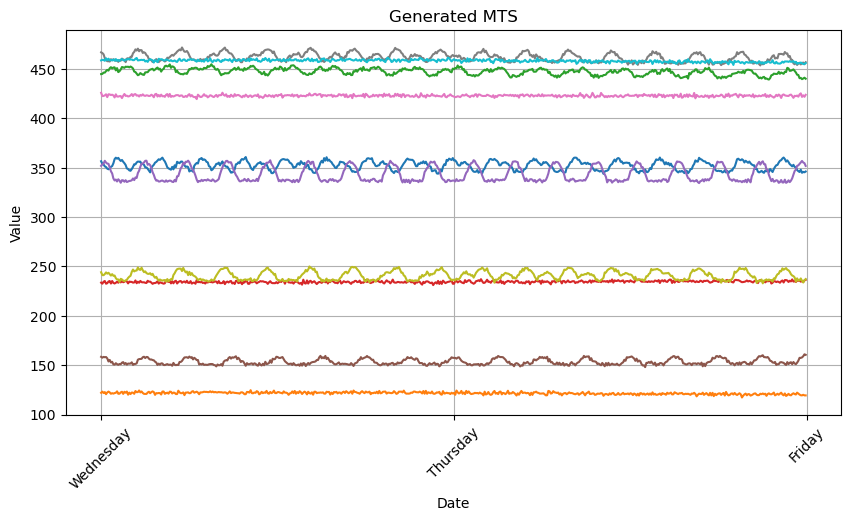

In [70]:
train_data, val_data, test_data, X = generate_labeled_data(args,
                                                           effects,
                                                           effect="both",
                                                           occurance=2,
                                                           return_gen=True,
                                                           anomalies=False)

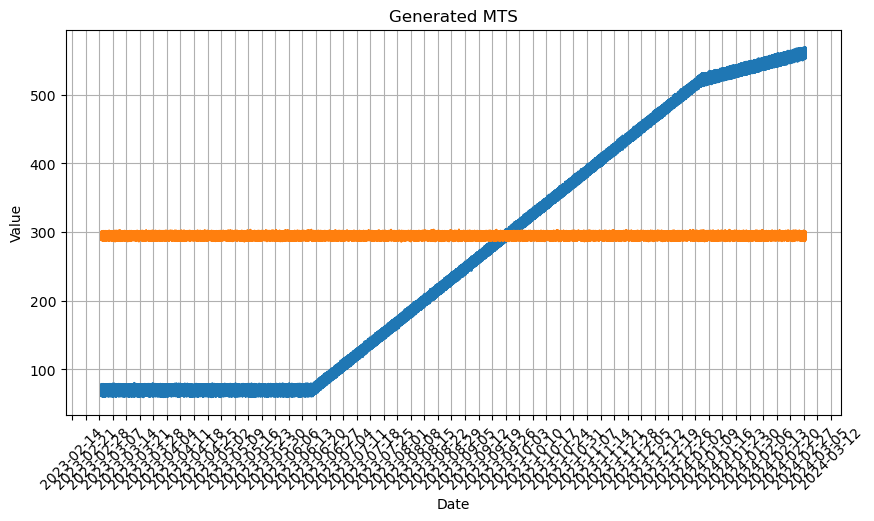

In [4]:
train_data_long, val_data_long, test_data_long, X_long = generate_long_data(args,
                                                                            effects,
                                                                            effect="both",
                                                                            occurance=2,
                                                                            return_gen=True,
                                                                            anomalies=False)

In [5]:
Origin_norm_long, REC_norm_long, _ = rebuild_TS_non_overlapping(vae, train_data_long, args, keep_norm=False)
denoised_rec_long = denoise_data(REC_norm_long.T.cpu())
denoised_orig_long = denoise_data(Origin_norm_long.T.cpu())
train_data_long_denoised = DataLoader(StridedWindow(torch.from_numpy(denoised_orig_long), args),  # slidingWindow, stridedWindow
                            batch_size=args.bs,  # 59, # 22
                            shuffle=False,
                            drop_last=False
                            )

In [71]:
x, params, e_params = X.parameters()
frs = e_params["Seasonality"]["frequency_per_week"]
arr = np.array(frs)
Origin_vae_norm, REC_vae_norm, _ = rebuild_TS(vae, train_data, args, keep_norm=True)
Origin_vae, REC_vae, z = rebuild_TS(vae, train_data, args, keep_norm=False)

Origin_vq_norm, REC_vq_norm, _ = rebuild_TS(vq, train_data, args, keep_norm=True)
Origin_vq, REC_vq, indices = rebuild_TS(vq, train_data, args, keep_norm=False)
# indices = indices.mean(axis=-1).type(torch.int32)

labels = extract_parameters(args, e_params=e_params, effects=effects)
labels = add_mu_std(labels, params)
train_labels = labels[:Origin_vae_norm.shape[0]]
                      
denoised_rec = denoise_data(REC_vae_norm.cpu())
denoised_orig = denoise_data(Origin_vae_norm.cpu())
train_data_denoised = DataLoader(NoWindow(torch.from_numpy(denoised_orig), args, train_labels, norm=True),  # slidingWindow, stridedWindow
                            batch_size=args.bs,  # 59, # 22
                            shuffle=False,
                            drop_last=False
                            )

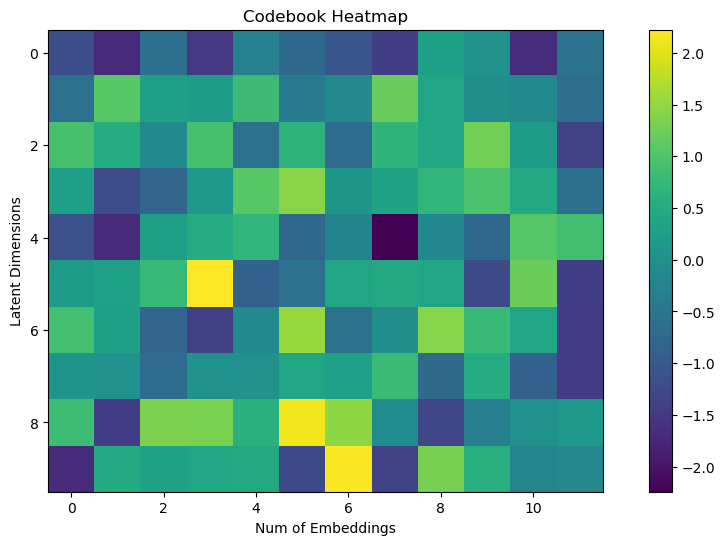

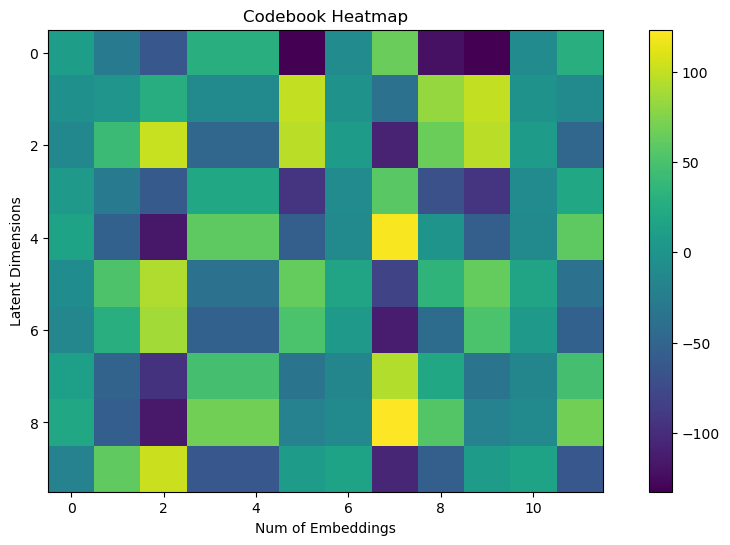

In [72]:

k=1
latent = z[k]
cb_index = indices[k]
# latent_vq
codebook = vq.quantizer._embedding.weight
latent_vq = codebook.index_select(0, cb_index)
heatmap = create_heatmap(latent)
heatmap = create_heatmap(latent_vq)


In [66]:
x, params, e_params = X.parameters()
frs = e_params["Seasonality"]["frequency_per_week"]
arr = np.array(frs)
arr[1]

AttributeError: 'DataFrame' object has no attribute 'parameters'

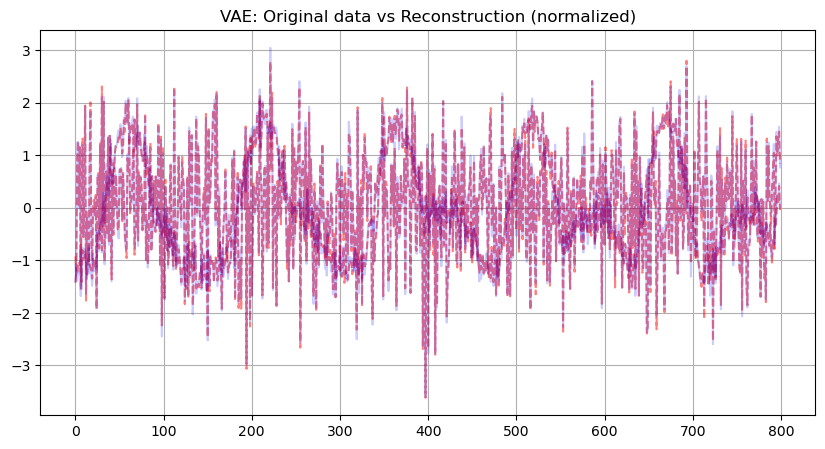

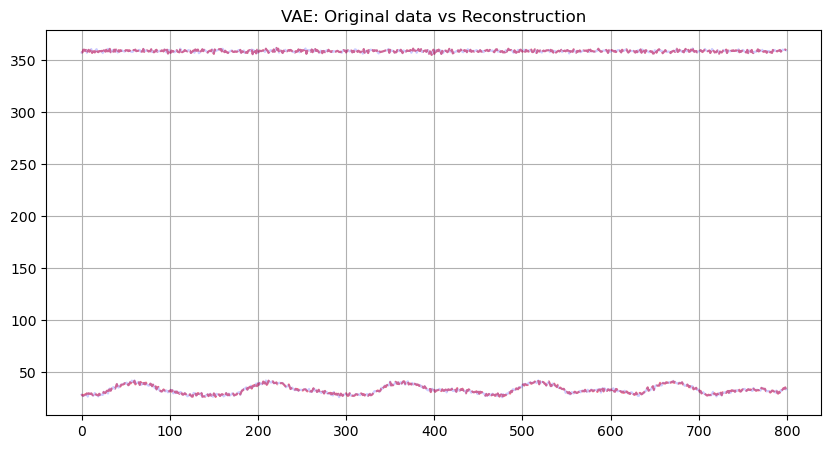

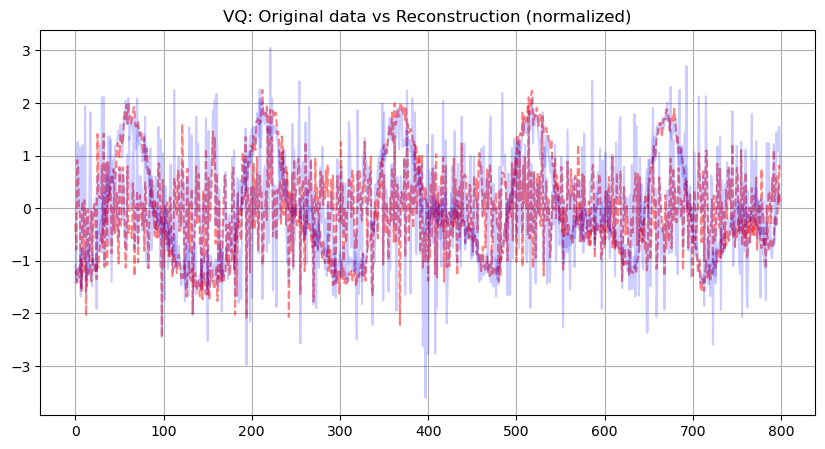

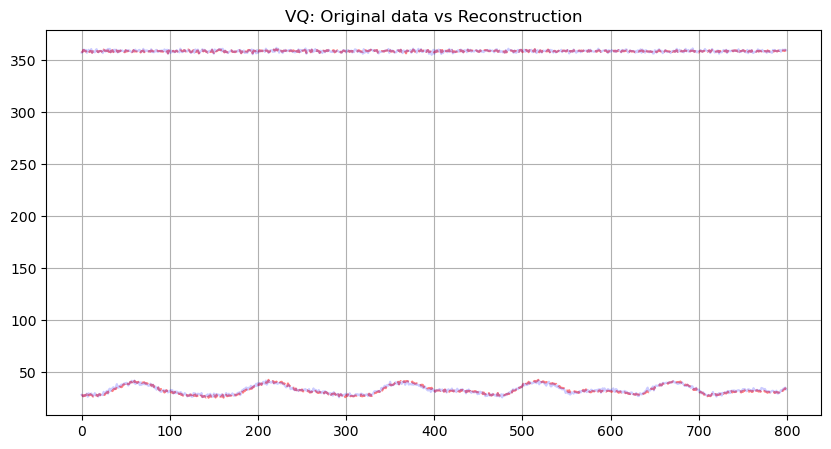

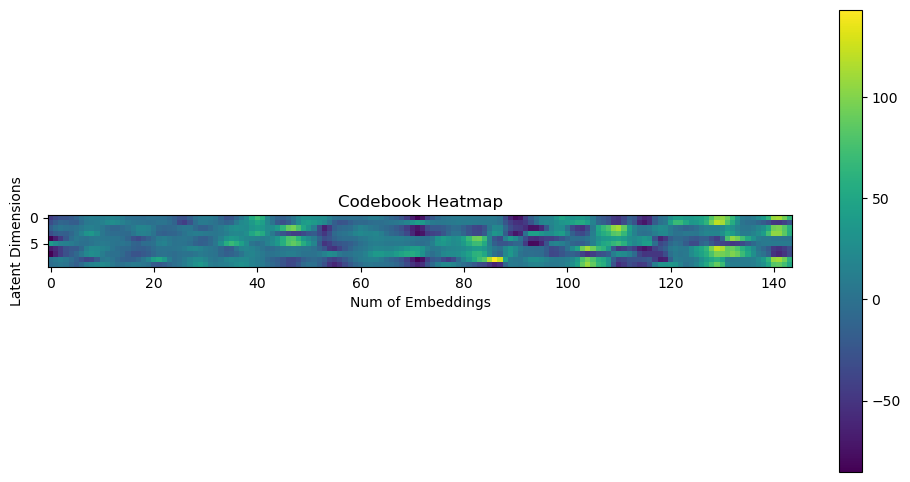

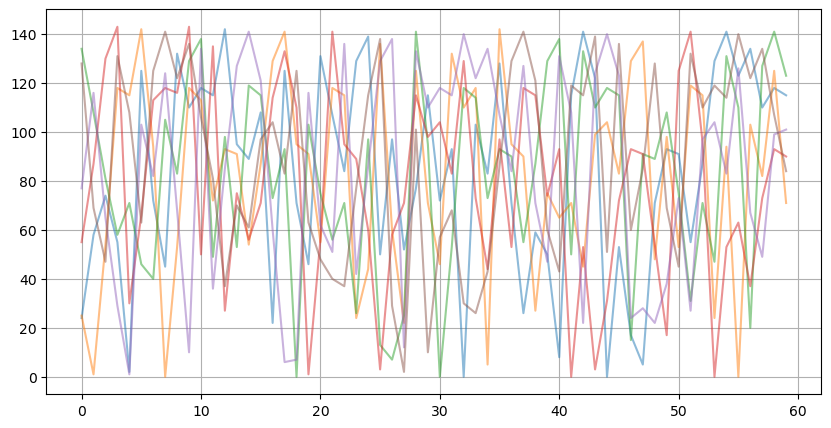

====> VAE: Sample 901 Average loss: 0.2840
====> VQ: Sample 901 Average loss: 2.0885
Train Epoch: 902 [0/1 (0%)]	Loss: 41.162274	 True Loss: 5968.529785
Train Epoch: 902 [0/1 (0%)]	Loss: 295.125458	 True Loss: 42793.191406
====> VAE: Sample 902 Average loss: 0.2839
====> VQ: Sample 902 Average loss: 2.0353
Train Epoch: 903 [0/1 (0%)]	Loss: 40.837180	 True Loss: 5921.391113
Train Epoch: 903 [0/1 (0%)]	Loss: 292.751886	 True Loss: 42449.023438
====> VAE: Sample 903 Average loss: 0.2816
====> VQ: Sample 903 Average loss: 2.0190
Train Epoch: 904 [0/1 (0%)]	Loss: 40.846555	 True Loss: 5922.750488
Train Epoch: 904 [0/1 (0%)]	Loss: 304.167295	 True Loss: 44104.257812
====> VAE: Sample 904 Average loss: 0.2817
====> VQ: Sample 904 Average loss: 2.0977
Train Epoch: 905 [0/1 (0%)]	Loss: 41.167039	 True Loss: 5969.220703
Train Epoch: 905 [0/1 (0%)]	Loss: 300.081600	 True Loss: 43511.832031
====> VAE: Sample 905 Average loss: 0.2839
====> VQ: Sample 905 Average loss: 2.0695
Train Epoch: 906 [0/1 (

Train Epoch: 940 [0/1 (0%)]	Loss: 40.355475	 True Loss: 5851.543945
Train Epoch: 940 [0/1 (0%)]	Loss: 294.686315	 True Loss: 42729.515625
====> VAE: Sample 940 Average loss: 0.2783
====> VQ: Sample 940 Average loss: 2.0323
Train Epoch: 941 [0/1 (0%)]	Loss: 40.443871	 True Loss: 5864.361328
Train Epoch: 941 [0/1 (0%)]	Loss: 281.116406	 True Loss: 40761.878906
====> VAE: Sample 941 Average loss: 0.2789
====> VQ: Sample 941 Average loss: 1.9387
Train Epoch: 942 [0/1 (0%)]	Loss: 40.277522	 True Loss: 5840.240723
Train Epoch: 942 [0/1 (0%)]	Loss: 295.859321	 True Loss: 42899.601562
====> VAE: Sample 942 Average loss: 0.2778
====> VQ: Sample 942 Average loss: 2.0404
Train Epoch: 943 [0/1 (0%)]	Loss: 40.125418	 True Loss: 5818.185547
Train Epoch: 943 [0/1 (0%)]	Loss: 283.831546	 True Loss: 41155.574219
====> VAE: Sample 943 Average loss: 0.2767
====> VQ: Sample 943 Average loss: 1.9575
Train Epoch: 944 [0/1 (0%)]	Loss: 40.344164	 True Loss: 5849.903809
Train Epoch: 944 [0/1 (0%)]	Loss: 289.60

Train Epoch: 977 [0/1 (0%)]	Loss: 39.685671	 True Loss: 5754.422363
Train Epoch: 977 [0/1 (0%)]	Loss: 299.030550	 True Loss: 43359.429688
====> VAE: Sample 977 Average loss: 0.2737
====> VQ: Sample 977 Average loss: 2.0623
Train Epoch: 978 [0/1 (0%)]	Loss: 39.641996	 True Loss: 5748.089355
Train Epoch: 978 [0/1 (0%)]	Loss: 288.516918	 True Loss: 41834.953125
====> VAE: Sample 978 Average loss: 0.2734
====> VQ: Sample 978 Average loss: 1.9898
Train Epoch: 979 [0/1 (0%)]	Loss: 39.839665	 True Loss: 5776.751465
Train Epoch: 979 [0/1 (0%)]	Loss: 287.627478	 True Loss: 41705.984375
====> VAE: Sample 979 Average loss: 0.2748
====> VQ: Sample 979 Average loss: 1.9836
Train Epoch: 980 [0/1 (0%)]	Loss: 40.036658	 True Loss: 5805.315430
Train Epoch: 980 [0/1 (0%)]	Loss: 298.270339	 True Loss: 43249.199219
====> VAE: Sample 980 Average loss: 0.2761
====> VQ: Sample 980 Average loss: 2.0570
Train Epoch: 981 [0/1 (0%)]	Loss: 39.759947	 True Loss: 5765.192383
Train Epoch: 981 [0/1 (0%)]	Loss: 298.63

In [74]:
args.min_max= False
np.set_printoptions(suppress=True)
VAE_losses = []
VQ_losses = []

for epoch in range(1, 1000):
    loss_vae = train(vae, train_data_long, args, opt_vae, epoch)
    loss_vq = train(vq, train_data_long, args, opt_vq, epoch)
    
    if epoch%100 == 1:
        display.clear_output(wait=True)
        show_results_long(vae, train_data_long, args)
        show_results_long(vq, train_data_long, args, vq=True)
        
    VAE_losses.append(loss_vae)
    VQ_losses.append(loss_vq)
                
    print('====> VAE: Sample {} Average loss: {:.4f}'.format(epoch, loss_vae / len(train_data_long.dataset)))
    print('====> VQ: Sample {} Average loss: {:.4f}'.format(epoch, loss_vq / len(train_data_long.dataset)))

In [39]:
pulses_indexs = indexs[np.where(channels == 1)]
pulses_indexs.sort(axis=0)
pulses_indexs.shape

(863,)

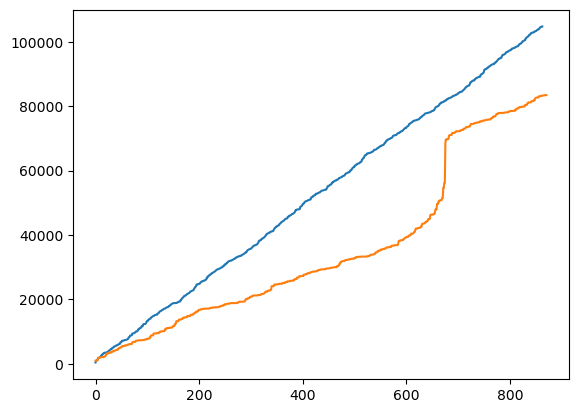

In [46]:
plt.plot(pulses_indexs)
plt.plot(anomalies)

In [45]:
rec_loss = (REC - Origin)**2
anomalies = np.where(rec_loss[:,1]>1200)[0]
anomalies.shape
# plt.plot(rec_loss[:2000,0])
# plt.ylim(0,20)

(871,)

289


<StemContainer object of 3 artists>

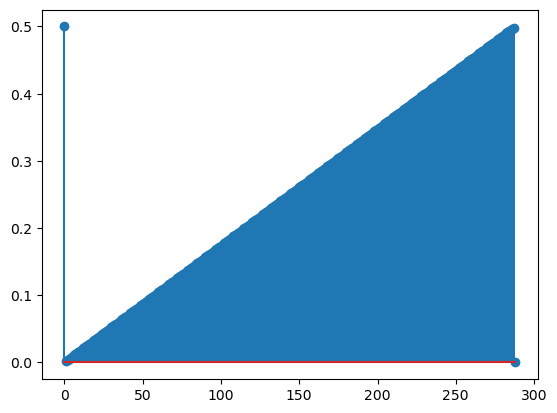

In [66]:
days = 7
# N = 288 * days
N=len(denoised_orig[1,0])
n=2
results = []
i = 0
Amps = sf.rfft(denoised_orig[1,0]) #/ N
freqs = sf.rfftfreq(n=N, d=1)
while len(results) < n:
#     i += 1
#     Amps = sf.rfft(denoised_orig[1,0]) #/ N
#     freqs = sf.rfftfreq(n=N, d=1)
    
    max_freq_ind = np.argpartition(np.abs(Amps), -i)[-i:]
#     results = filter_close_values(freqs[max_freq_ind], 0.02)
    results = freqs[max_freq_ind]
# print(max_freq_ind)
# print(abs(Amps[max_freq_ind]))
print(len(freqs))
# print(results)
# print([result%14 for result in results])
print(0.001736111111111111*12*24*7*2)

plt.stem(freqs[max_freq_ind])
# frs

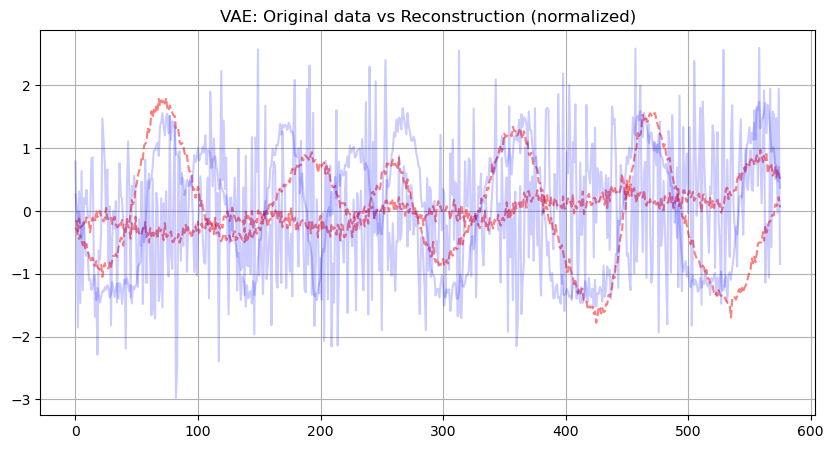

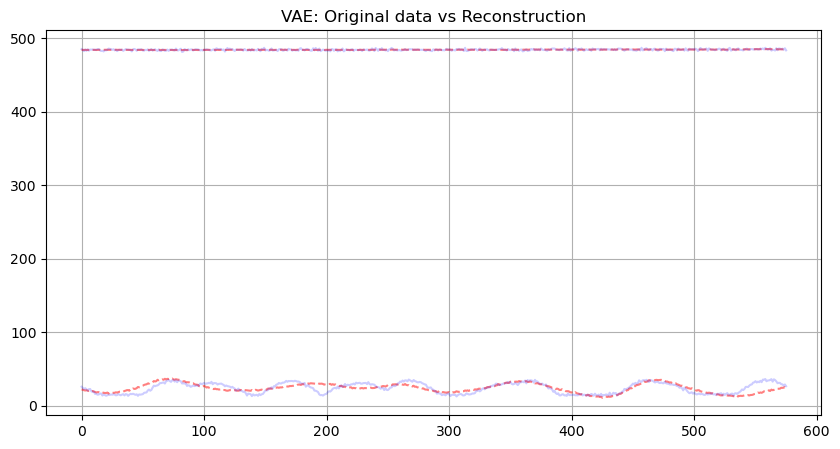

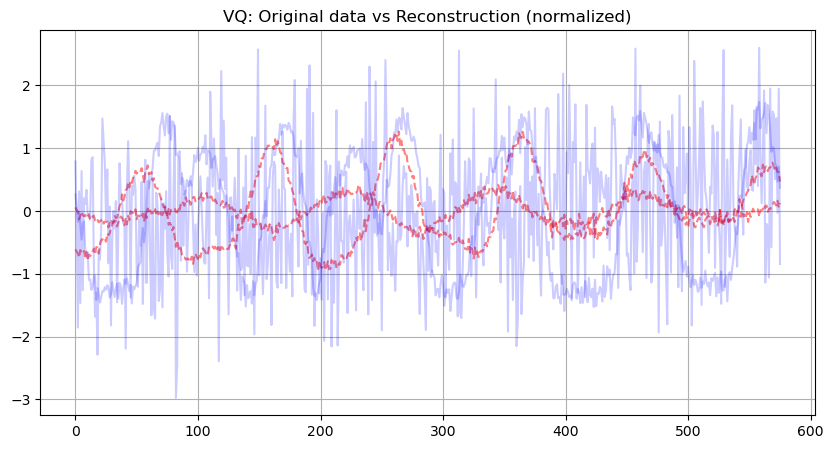

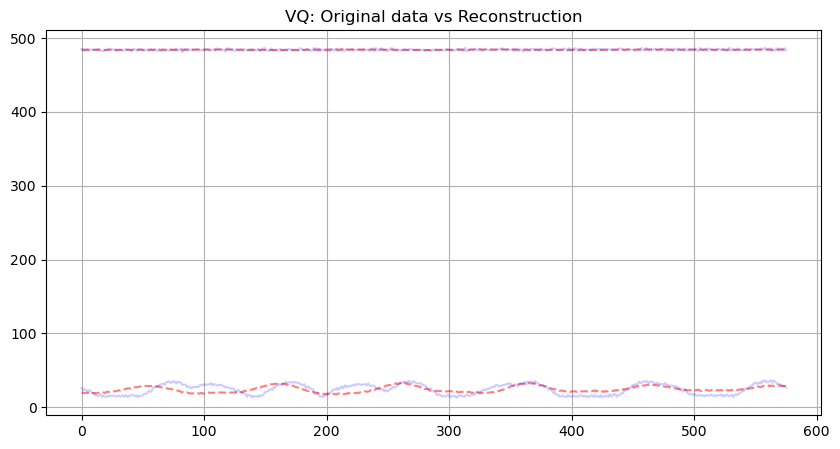

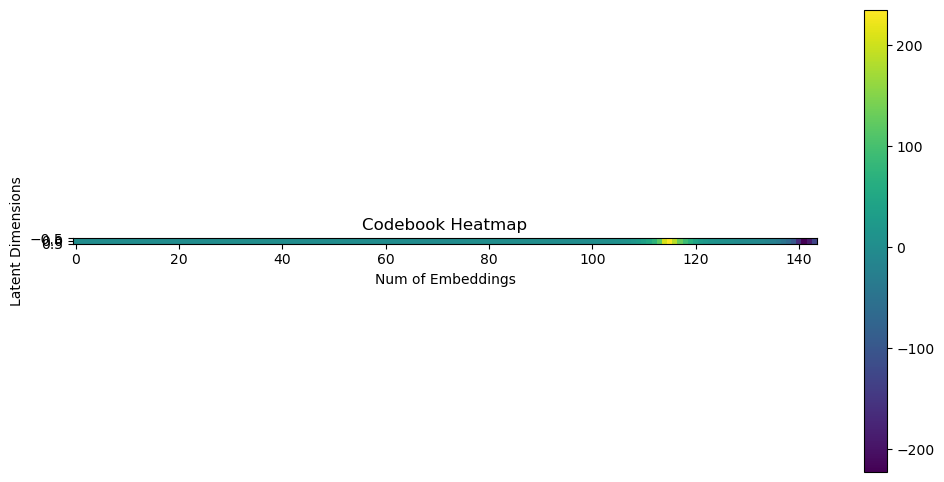

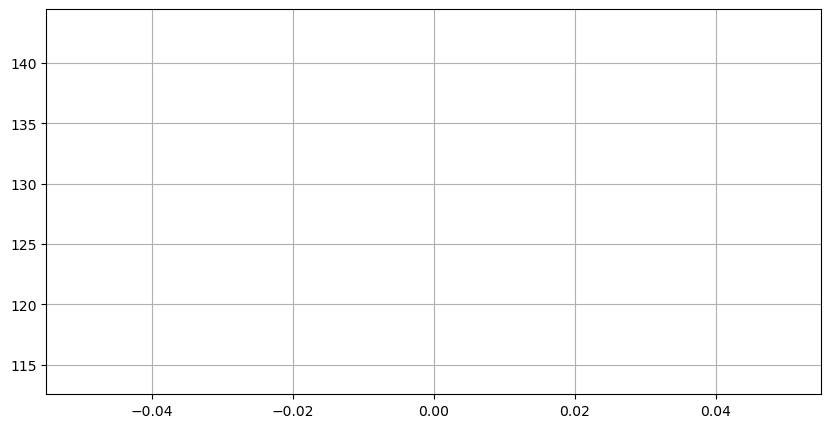

====> VAE: Sample 91 Average loss: 0.1212
====> VQ: Sample 91 Average loss: 0.1838
Train Epoch: 92 [0/16 (0%)]	Loss: 462.099304	 True Loss: 118297.421875
Train Epoch: 92 [0/16 (0%)]	Loss: 711.662659	 True Loss: 182185.640625
====> VAE: Sample 92 Average loss: 0.1209
====> VQ: Sample 92 Average loss: 0.1834
Train Epoch: 93 [0/16 (0%)]	Loss: 462.034668	 True Loss: 118280.875000
Train Epoch: 93 [0/16 (0%)]	Loss: 710.233765	 True Loss: 181819.843750
====> VAE: Sample 93 Average loss: 0.1207
====> VQ: Sample 93 Average loss: 0.1831
Train Epoch: 94 [0/16 (0%)]	Loss: 460.932861	 True Loss: 117998.812500
Train Epoch: 94 [0/16 (0%)]	Loss: 712.921997	 True Loss: 182508.031250
====> VAE: Sample 94 Average loss: 0.1204
====> VQ: Sample 94 Average loss: 0.1824
Train Epoch: 95 [0/16 (0%)]	Loss: 460.560638	 True Loss: 117903.523438
Train Epoch: 95 [0/16 (0%)]	Loss: 706.635010	 True Loss: 180898.562500
====> VAE: Sample 95 Average loss: 0.1202
====> VQ: Sample 95 Average loss: 0.1824
Train Epoch: 96 [

In [34]:
np.set_printoptions(suppress=True)
VAE_losses = []
VQ_losses = []

for epoch in range(1, 100):
    loss_vae = train(vae, train_data, args, opt_vae, epoch)
    loss_vq = train(vq, train_data, args, opt_vq, epoch)
    
    if epoch%10 == 1:
        display.clear_output(wait=True)
        show_results(vae, train_data, args)
        show_results(vq, train_data, args, vq=True)
        
    VAE_losses.append(loss_vae)
    VQ_losses.append(loss_vq)
        
    print('====> VAE: Sample {} Average loss: {:.4f}'.format(epoch, loss_vae / len(train_data.dataset)))
    print('====> VQ: Sample {} Average loss: {:.4f}'.format(epoch, loss_vq / len(train_data.dataset)))

In [8]:
def rescale_x_axis(ts, args):
    n = len(ts)
    t = np.arange(n)
    scale_factor = 182 *args.split[0]
    new_n =41761*2# int(scale_factor * n)
    print(scale_factor, n)

    # Generate new time vector and zero-padded time series
    new_t = np.linspace(0, n - 1, new_n)
    new_ts = np.interp(new_t, t, ts)
    return new_ts

In [72]:
def rescale_x_axis(ts, args):
    n = len(ts)
    t = np.arange(n)
    scale_factor = 182 *args.split[0]
    new_n =41761*2# int(scale_factor * n)
    print(scale_factor, n)

    # Generate new time vector and zero-padded time series
    new_t = np.linspace(0, n - 1, new_n)
    new_ts = np.interp(new_t, t, ts)
    return new_ts

def find_freqs_p(denoised, n):
    new_ts = rescale_x_axis(denoised, args)
#     new_ts = denoised
    freqs_w = []
    i = 0
    sample_rate = 12*24*7*2*365
#     sample_rate = 1
    N=len(new_ts)
#     print(new_ts.shape)
    X = sf.rfft(new_ts) #/ N
    freqs = sf.rfftfreq(n=N, d=1/sample_rate)
#     print(freqs[-1], len(freqs))
    while len(freqs_w) < n:
        i += 1
        
#         print(X.shape)
#         print(np.argpartition(np.abs(X), -i))
        max_freq_ind = np.argpartition(np.abs(X), -i)[-i:]
#         print(i, freqs_w, len(freqs_w))
        freqs_w = filter_close_values(freqs[max_freq_ind][:n], 0.005)
#     print(max_freq_ind)
#         print(freqs_w, len(freqs_w))
#     plt.stem(freqs[max_freq_ind])
    
        
#     results = [fs*364/2% 14 for fs in freqs_w]
    return np.array(freqs_w, dtype=np.float64)

In [73]:
k=10
# res_rec = find_freqs_p(denoised_orig[k,0],2)
res_orig = find_freqs_p(denoised_orig[k,0],5)
# print(find_freqs_p(denoised[k,0],2))
print(np.sort(res_orig))
# print(np.sort(res_rec))
print(np.sort(arr[k]))

145.6 576
735840.0 41762
[ 5 18  4  3  2  1]
[ 35.24053543  52.86080314  70.48107086  88.10133857 317.16481885]
[56.39525306 61.04465313]


Identified periodicities: [59.294117647058826, 30.08955223880597]


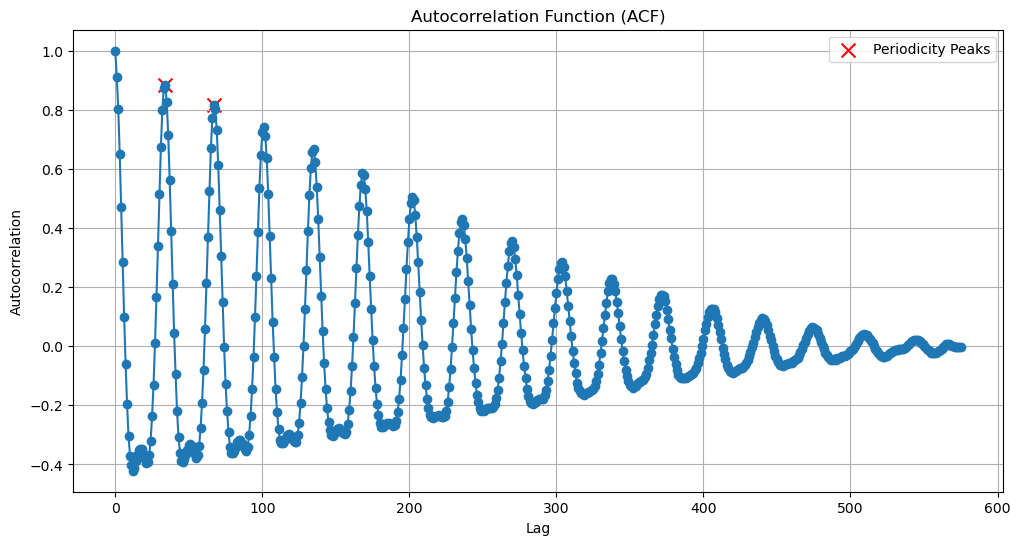

In [262]:
from scipy.signal import find_peaks
autocorr = acf[0,0]
identify_frequencies(autocorr, args, 2)

def identify_frequencies(autocorr, args, n_frequencies=1):
    # Plot the autocorrelation function (ACF)
    plt.figure(figsize=(12, 6))
    plt.plot(autocorr, marker='o', linestyle='-')
    plt.title('Autocorrelation Function (ACF)')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.grid(True)

    # Find significant peaks in the ACF
    # We consider lags up to half the length of the autocorrelation values
    threshold = 0.8
    min_to_week = 7*24*60
    max_lag = len(autocorr) // 2
    peaks, _ = find_peaks(autocorr[:max_lag])
    periodicities = [lag for lag in peaks if autocorr[lag] > threshold][:n_frequencies]

    # Output the identified periodicities
    print("Identified periodicities:",[(( 1/(periodicity*args.step) ) * min_to_week) for periodicity in periodicities])

    # Plot the ACF with identified periodicities
    plt.scatter(periodicities, [autocorr[lag] for lag in periodicities], color='red', marker='x', s=100, label='Periodicity Peaks')
    plt.legend()
    plt.show()

In [263]:
frs = e_params["Seasonality"]["frequency_per_week"]
arr = np.array(frs)
arr[0]

array([59.47088182, 60.92424875])

In [240]:
(1/(34*5))*7*24*60

59.294117647058826

In [241]:
[((1/(periodicity*5))*7*24*60)%63 for periodicity in periodicities]

[61.0909090909091]

In [98]:
arr[10]

array([60.40446709, 58.65308433])

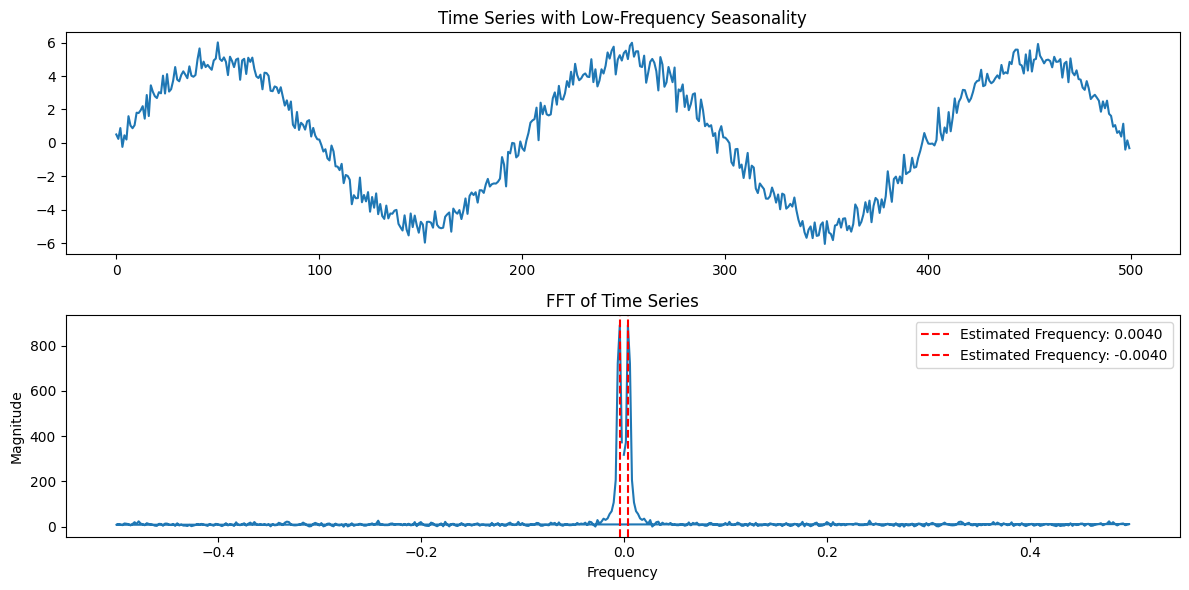

In [140]:
from scipy.signal import find_peaks

# Create a time series with low-frequency seasonality
n = 500
t = np.arange(n)
frequency = 0.005  # Low-frequency seasonality
seasonality = 5 * np.sin(2 * np.pi * frequency * t)
noise = np.random.normal(0, 0.5, n)
time_series = seasonality + noise

# Compute the FFT
fft_result = np.fft.fft(time_series)
sampling_frequency = 1  # Assuming unit sampling frequency
frequencies = np.fft.fftfreq(n, d=1 / sampling_frequency)

# Identify the peaks in the FFT magnitude plot
peaks, _ = find_peaks(np.abs(fft_result), 600)

# Extract corresponding frequencies
peak_frequencies = frequencies[peaks]

# Plot the time series and the estimated frequencies
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, time_series)
plt.title('Time Series with Low-Frequency Seasonality')

plt.subplot(2, 1, 2)
plt.plot(frequencies, np.abs(fft_result))
plt.title('FFT of Time Series')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')

# Plot the estimated frequencies
for freq in peak_frequencies:
    plt.axvline(x=freq, color='r', linestyle='--', label=f'Estimated Frequency: {freq:.4f}')
plt.legend()

plt.tight_layout()
plt.show()

In [58]:
11.27865253/res[0]

1.0741573838095237

In [29]:
find_freqs_p(denoised[1,0],2)
arr[1]

NameError: name 'find_freqs_p' is not defined

In [97]:
def find_freqs(denoised, n):
    freqs_w = []
    i = 0
    sample_rate = 24*12*7
    N=len(denoised)
#     print(denoised.shape)
    X = sf.rfft(denoised) #/ N
    freqs = sf.rfftfreq(n=N, d=1/sample_rate)
    print(freqs[-1], len(freqs))
    while len(freqs_w) < n:
        i += 1
        
#         print(X.shape)

        max_freq_ind = np.argpartition(np.abs(X), -i)[-i:]
#         print(freqs[max_freq_ind])
        freqs_w = filter_close_values(freqs[max_freq_ind], 0.2)
#         print(freqs_w)
    print(freqs[-1], len(freqs))
        
    results = [fs % 14 for fs in freqs_w]
    return np.array(results, dtype=np.float64)

In [95]:
def get_frequencies_per_week_long(v, train_data, args, n):
#     data = train_data.dataset.data
#     shape = data.shape[:-1]
#     N = data.shape[-1]

    Origin_norm, REC_norm, _ = rebuild_TS_non_overlapping(v, train_data, args, keep_norm=True)
    denoised = denoise_data(REC_norm.T.cpu())


    
    freqs = np.empty((args.n_channels, n))
    for i, fs in enumerate(freqs):
        fs = find_freqs(denoised[i], n)
    

#     print(freqs_w)
#     print([fs % 14 for fs in freqs_w])

    return fs

In [71]:
def get_frequencies_per_week(v, train_data, args, n):

    Origin_norm, REC_norm, _ = rebuild_TS(v, train_data, args, keep_norm=True)
    denoised = denoise_data(Origin_norm.cpu())


    freqs = np.empty((denoised.shape[0], args.n_channels, n))
    for i, sample in enumerate(freqs):
#         print(i)
        for j, fs in enumerate(sample):
            fs = find_freqs_p(denoised[i, j], n)
            freqs[i,j] = fs
    return freqs

In [72]:
fs = get_frequencies_per_week(vae, train_data, args, n=5)
x, params, e_params = X.parameters()
frs = e_params["Seasonality"]["frequency_per_week"]
arr = np.array(frs)
arr[0]

# print(fs)
# frs

182.5 576
0.5 52561


KeyboardInterrupt: 

In [98]:
fs = get_frequencies_per_week_long(vae, train_data_long, args, n=3)
x_long, params_long, e_params_long = X_long.parameters()
frs = e_params_long["Seasonality"]["frequency_per_week"][0]
print(fs)
frs

1008.0000000000001 41761


KeyboardInterrupt: 

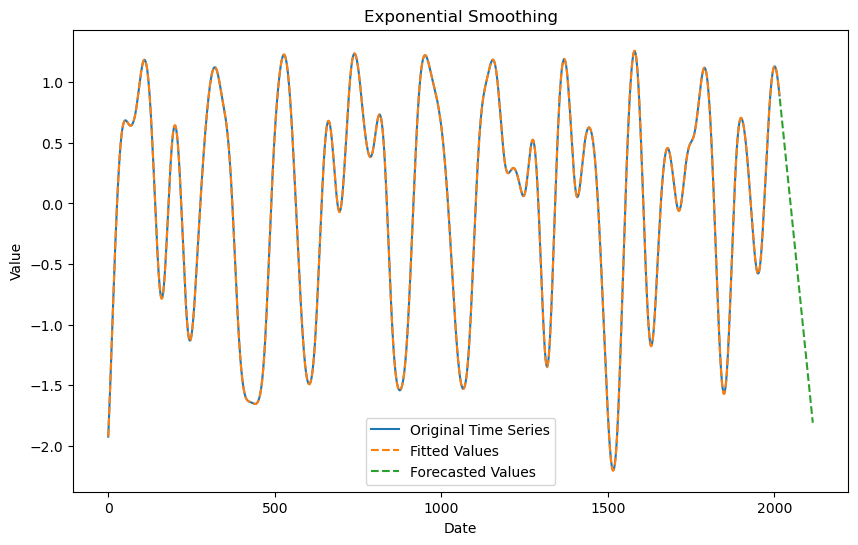

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Create an example time series dataset
np.random.seed(0)
n = 100
t = np.arange(n)
noise = np.random.normal(0, 0.5, n)
time_series = 2 * t + 10 * np.sin(0.1 * t) + noise

# Convert the data to a pandas Series (with dates) for time-based analysis
# date_range = pd.date_range(start='2023-01-01', periods=, freq='D')
ts_data = pd.Series(denoised[0][:288*7])

# Apply exponential smoothing
exponential_smoothing = sm.tsa.ExponentialSmoothing(ts_data, trend='add', seasonal=None)
fitted_model = exponential_smoothing.fit()

# Forecast using the fitted model
forecast = fitted_model.forecast(steps=100)  # Forecast the next 10 time points

# Plot the original time series and the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(ts_data, label='Original Time Series')
plt.plot(fitted_model.fittedvalues, label='Fitted Values', linestyle='--')
plt.plot(forecast, label='Forecasted Values', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.title('Exponential Smoothing')
plt.show()

In [135]:
data = train_data_long.dataset.data
data.numpy().shape

(2, 83865)

/tmp/ipykernel_9355/464481837.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{a}' for a in range(days+1)])


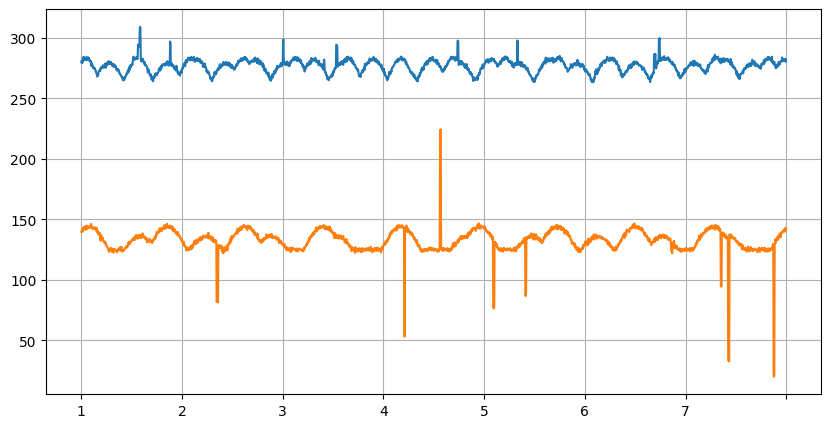

In [136]:
from matplotlib.ticker import MultipleLocator

days = 7
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(data.T[:288*days])
plt.grid(True)
x_locator = MultipleLocator(base=288)
ax.xaxis.set_major_locator(x_locator)
ax.set_xticklabels([f'{a}' for a in range(days+1)])
# ax.xaxis.set_major_formatter('{:.0f}'.format)
plt.show()

In [137]:
mean_global = data.mean(dim=1, keepdim=True)
std_global = data.std(dim=1, keepdim=True)
for i, (data, label, norm) in enumerate(train_data_long):
    denorm_data = revert_standarization(data, norm)
    mean_window = denorm_data.mean(dim=-1)
    std_window = denorm_data.std(dim=-1)

TypeError: only integer tensors of a single element can be converted to an index

In [459]:
x_long, params_long, e_params_long = X_long.parameters()
frs = e_params_long["Seasonality"]["frequency_per_week"][0]
frs

array([ 9.12847645,  8.751179  , 11.507779  ])

In [402]:
e_params_long["Seasonality"]["amplitude"][0]

array([18,  6])

In [14]:
def denoise_data(data):
    denoised = np.empty_like(data)
    for i, d in enumerate(data):
        denoised[i] = denoise(d.unsqueeze(0).cpu())
    return denoised

Origin_norm, REC_norm, _ = rebuild_TS_non_overlapping(v, train_data_long, args, keep_norm=True)
denoised = denoise_data(Origin_norm.T.cpu())

In [461]:
def filter_close_values(input_list, threshold):
    if len(input_list) <= 1:
        return input_list  # Nothing to filter if the list has 0 or 1 element

    input_list.sort()  # Sort the list in ascending order
    filtered_list = [input_list[0]]

    for value in input_list[1:]:
        if abs(value - filtered_list[-1]) > threshold and (abs(value % filtered_list) > threshold).all():
            filtered_list.append(value)

    return filtered_list

In [1058]:
denoised.shape

(4000, 1, 8064)

[0.]
Dominant frequencies: []


ValueError: x and y must have same first dimension, but have shapes (1,) and (8064,)

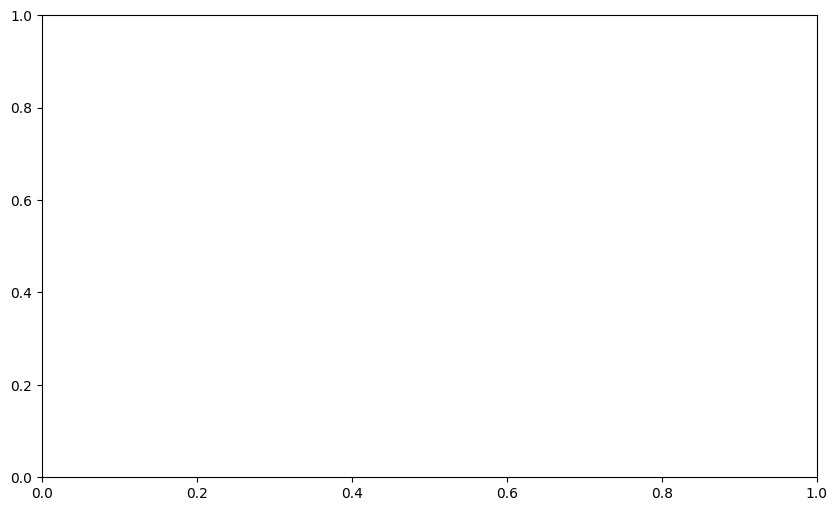

In [1059]:
from scipy.signal import find_peaks

# # Sample data with two seasonalities
n = len(denoised[0]) # 400
sampling_rate  = 1
# t = np.arange(0, n)
# sampling_rate = 10  # Increase the sampling rate
# t = t / sampling_rate  # Adjust the time vector accordingly
# time_series = 5 * np.sin(0.1 * t * 2 * np.pi) + 2 * np.sin(0.4 * t * 2 * np.pi)

# Compute the FFT
fft_result = np.fft.fft(denoised[0,0])

# Calculate frequencies
frequencies = np.fft.fftfreq(n, d=1/(24*12*7))
print(frequencies)

# Find peaks in the FFT magnitude
peaks, _ = find_peaks(np.abs(fft_result), height=np.max(fft_result))  # Adjust the height threshold as needed

# Extract corresponding frequencies
peak_frequencies = np.abs(frequencies[peaks])

print("Dominant frequencies:", peak_frequencies)

# Plot the FFT
plt.figure(figsize=(10, 6))
plt.plot(frequencies, np.abs(fft_result))
plt.title('FFT of Time Series')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid()
plt.show()

In [817]:
1008/(24*12*7)

0.5

[37  0]
[1002.93164 3740.3425 ]
[   0.      0.25    0.5  ... 1007.5  1007.75 1008.  ]


<StemContainer object of 3 artists>

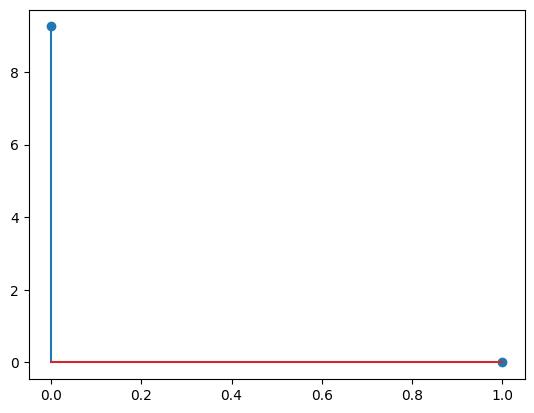

In [1060]:
days = 7
# N = 288 * days
N=len(denoised[0,0])
n=2
results = []
i = 0
while len(results) < n:
    i += 1
    X = sf.rfft(denoised[0,0]) #/ N
    freqs = sf.rfftfreq(n=N, d=1/(24*12*7))
    
    max_freq_ind = np.argpartition(np.abs(X), -i)[-i:]
#     results = filter_close_values(freqs[max_freq_ind], 0.2)
    results = freqs[max_freq_ind]
print(max_freq_ind)
print(abs(X[max_freq_ind]))
print((freqs))
# print(results)
# print([result%14 for result in results])

plt.stem(freqs[max_freq_ind])
# frs

In [809]:
def get_frequencies_per_week(v, train_data, args, n):
    
    Origin_norm, REC_norm, _ = rebuild_TS_non_overlapping(v, train_data, args, keep_norm=True)
    denoised = denoise_data(Origin_norm.T.cpu())

    N=len(denoised[0])
    freqs_w = []
    i = 0
    while len(freqs_w) < n:
        i += 1
        X = sf.rfft(denoised[0]) #/ N
        freqs = sf.rfftfreq(n=N, d=1/(24*12*7))

        max_freq_ind = np.argpartition(np.abs(X), -i)[-i:]
        freqs_w = filter_close_values(freqs[max_freq_ind], 0.2)

#     print(freqs_w)
#     print([fs % 14 for fs in freqs_w])
    results = [fs % 14 for fs in freqs_w]

    return results

In [15]:
get_frequencies_per_week(v, train_data_long, args, n=3)
x_long, params_long, e_params_long = X_long.parameters()
frs = e_params_long["Seasonality"]["frequency_per_week"][0]
frs

[8.810344827586208, 10.210344827586209, 13.493103448275864]
[8.810344827586208, 10.210344827586209, 13.493103448275864]


array([ 8.82219493, 13.48370278, 10.20135647])

In [204]:
N/(288*7)

1.0

(1009,)
[ 8  6  7 11 15]
[255.40695 298.44864 699.44946 662.7711  397.8458 ]
[112.  84.  98. 154. 210.]


array([ 9.40703251, 10.85850522, 10.41877301,  7.38420925])

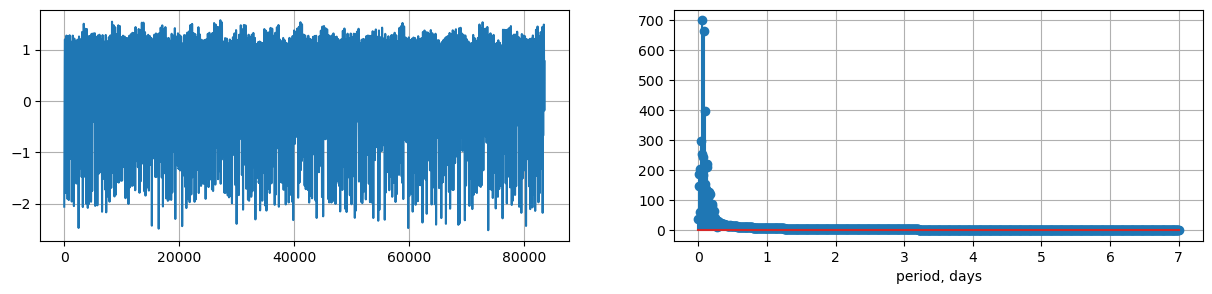

In [220]:
import scipy.fft as sf
import matplotlib.ticker as tck

days = 7
N = 288 * days
# N = denoised.shape[-1]
X = sf.rfft(denoised[0][:N]) #/ N
freqs = sf.rfftfreq(n=N, d=1/(days*2))

print(X.shape)
# Plot signal
fig, axes = plt.subplots(figsize=(15,3), ncols=2)
ax=axes[0]
ax.plot(denoised[0])
# ax.xaxis.set_major_locator(tck.MultipleLocator(50))
ax.grid()

# # Plot DFT
ax=axes[1]
extent = 288*7 -1#288*7#N
ax.set_xlabel('period, days')
# ax.stem(freqs[:extent], abs(X[:extent]))
ax.stem(freqs, abs(X))

# x_locator = MultipleLocator(base=288)
# ax.xaxis.set_major_locator(x_locator)
# ax.set_xticklabels([f'{a}' for a in range(days+1)])
# ticks = ax.get_xticks()
# ax.set_xticklabels([f'{a}' for a in range(1000)])
# ax.invert_xaxis()
ax.grid()
np.set_printoptions(suppress=True)

# print(np.argmax(X))
n=5
max_freq_ind = np.argpartition(np.abs(X), -n)[-n:]
print(max_freq_ind)
print(abs(X[max_freq_ind]))
print(freqs[max_freq_ind]*N)
frs

In [571]:
Origin_norm.shape

torch.Size([83520, 1])

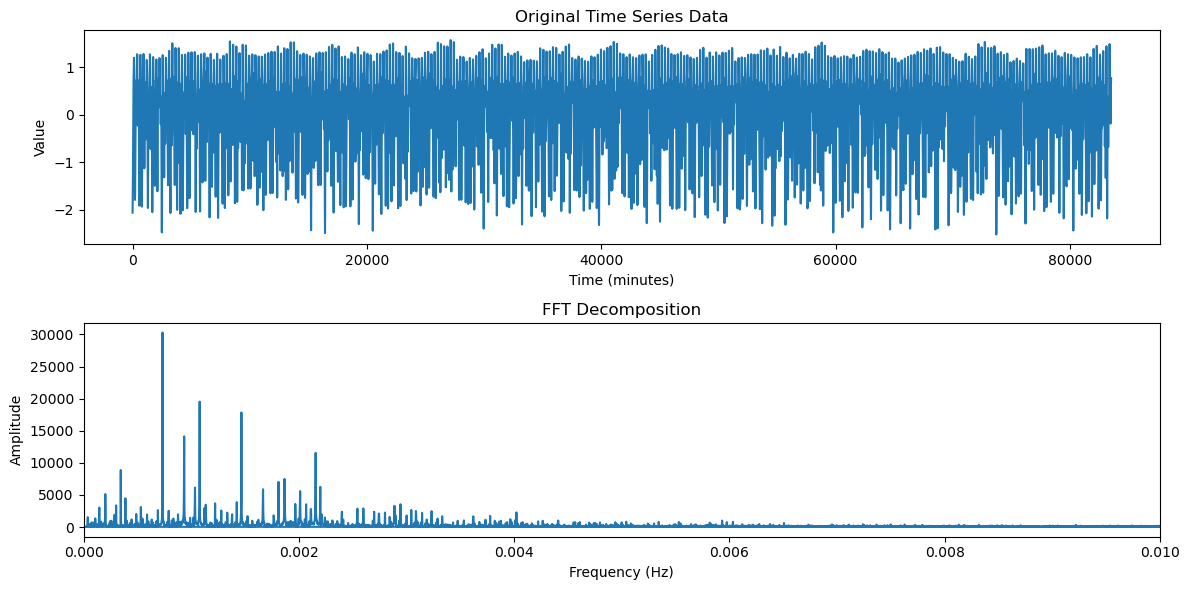

In [221]:
# Define your time series data with a 3-day seasonality
sampling_rate = 5  # 5 minutes between data points
num_points = denoised_orig.shape[0]  # Number of data points (assuming 5-minute intervals in a day)

# Create a time vector in minutes
time = np.arange(0, num_points)# * sampling_rate

# # Create a synthetic time series with a 3-day seasonality
# seasonality_freq = 1 / (3 * 24 * 60)  # Frequency in Hz (3 days in minutes)
# amplitude = 10  # Amplitude of the seasonality
# noise = np.random.normal(0, 1, num_points)  # Add some random noise
# data = amplitude * np.sin(2 * np.pi * seasonality_freq * time) + noise

# Perform FFT on the data
fft_result = np.fft.fft(Origin_norm[:,0].cpu())
frequencies = np.fft.fftfreq(denoised.shape[-1], d=sampling_rate)

# Plot the original data
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time, denoised[0])
plt.title("Original Time Series Data")
plt.xlabel("Time (minutes)")
plt.ylabel("Value")

# Plot the FFT results
plt.subplot(2, 1, 2)
plt.plot(frequencies, np.abs(fft_result))
plt.title("FFT Decomposition")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.xlim(0, 0.01)  # Limit the x-axis to relevant frequencies

plt.tight_layout()
plt.show()


In [222]:
N = 10  # Adjust N as needed
max_amplitude_indices = np.argpartition(np.abs(fft_result), -N)[-N:]
# Get the corresponding frequency in Hertz
max_frequencies = frequencies[max_amplitude_indices]
positive_frequencies = max_frequencies[max_frequencies > 0]
print("Dominant Frequency:", positive_frequencies, "Hz")
np.set_printoptions(suppress=True)



Dominant Frequency: [0.00215517 0.00093391 0.00107759 0.00073276 0.00146552] Hz


In [223]:
np.sort(7 / (positive_frequencies * 24 * 60))

array([2.25555556, 3.31699346, 4.51111111, 5.20512821, 6.63398693])

In [224]:
np.sort(frs)

array([ 7.38420925,  9.40703251, 10.41877301, 10.85850522])

In [215]:
x_long, params_long, e_params_long = X_long.parameters()
frs = e_params_long["Seasonality"]["frequency_per_week"][0]
frs/(7*288)

array([0.00466619, 0.00538616, 0.00516804, 0.0036628 ])

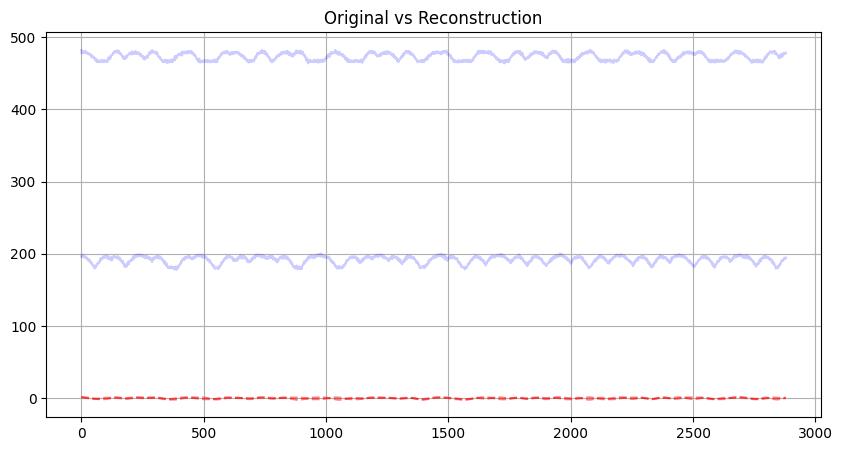

In [217]:
plot_rec(data.T[:args.L*5], denoised.T[:args.L*5])

In [214]:
denoised.shape

(2, 83520)

In [298]:
r = np.correlate(denoised[0][:args.L*20], denoised[0][:args.L], mode='full')[args.L*10:]
print(denoised.shape, r.shape)

(2, 83520) (6335,)


Text(0.5, 0, 'Lag (samples)')

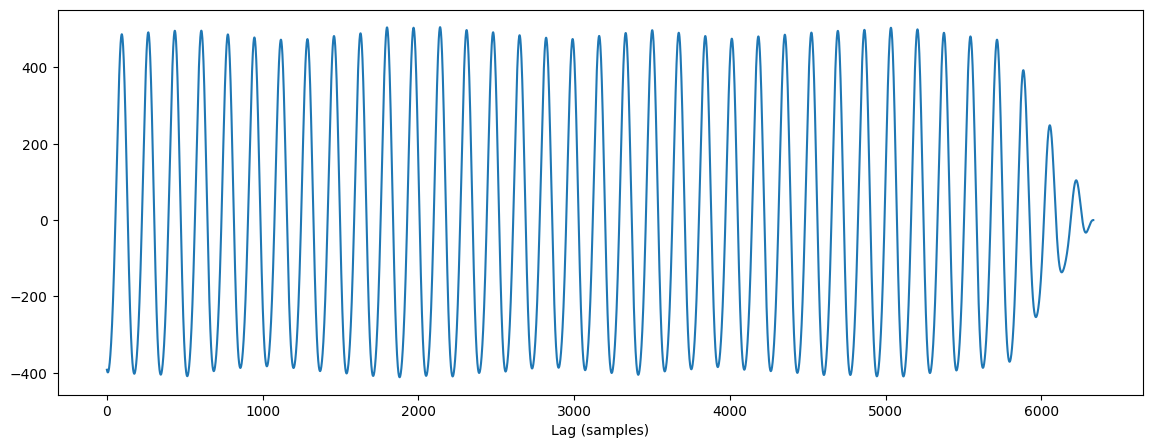

In [299]:
plt.figure(figsize=(14, 5))
plt.plot(r)
plt.xlabel('Lag (samples)')
# plt.xlim(0, 10000)

In [313]:
idx=np.argpartition(r, -10)[-10:]

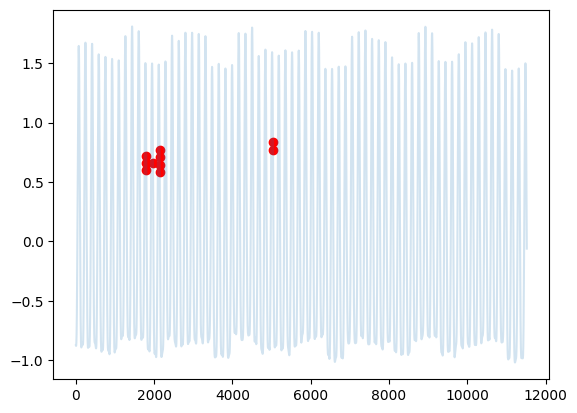

In [314]:
x= np.arange(len(denoised[0][:args.L*20]))
y = denoised[0][:args.L*20]
plt.plot(y, alpha=0.2)
plt.scatter(x[idx], y[idx], color='red', label='Dot at Index {}'.format(2901))


In [10]:
from statsmodels.graphics.tsaplots import plot_acf

In [304]:
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''

    corr=[1. if l==0 else np.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return np.array(corr)

def autocorr2(x,lags):
    '''manualy compute, non partial'''

    mean=np.mean(x)
    var=np.var(x)
    xp=x-mean
    corr=[1. if l==0 else np.sum(xp[l:]*xp[:-l])/len(x)/var for l in lags]

    return np.array(corr)

def autocorr3(x,lags):
    '''fft, pad 0s, non partial'''

    n=len(x)
    # pad 0s to 2n-1
    ext_size=2*n-1
    # nearest power of 2
    fsize=2**np.ceil(np.log2(ext_size)).astype('int')

    xp=x-np.mean(x)
    var=np.var(x)

    # do fft and ifft
    cf=np.fft.fft(xp,fsize)
    sf=cf.conjugate()*cf
    corr=np.fft.ifft(sf).real
    corr=corr/var/n

    return corr[:len(lags)]

def autocorr4(x,lags):
    '''fft, don't pad 0s, non partial'''
    mean=x.mean()
    var=np.var(x)
    xp=x-mean

    cf=np.fft.fft(xp)
    sf=cf.conjugate()*cf
    corr=np.fft.ifft(sf).real/var/len(x)

    return corr[:len(lags)]

def autocorr5(x,lags):
    '''numpy.correlate, non partial'''
    mean=x.mean()
    var=np.var(x)
    xp=x-mean
    corr=np.correlate(xp,xp,'full')[len(x)-1:]/var/len(x)

    return corr[:len(lags)]

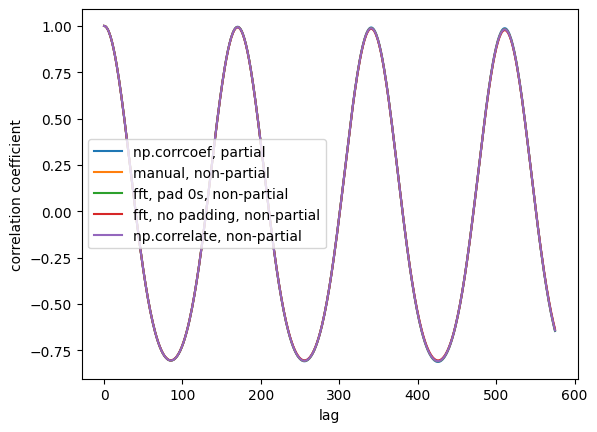

In [305]:
y=[28,28,26,19,16,24,26,24,24,29,29,27,31,26,38,23,13,14,28,19,19,\
            17,22,2,4,5,7,8,14,14,23]
y=np.array(y).astype('float')

# lags=range(15)
lags=range(args.L)
fig,ax=plt.subplots()

for funcii, labelii in zip([autocorr1, autocorr2, autocorr3, autocorr4,
    autocorr5], ['np.corrcoef, partial', 'manual, non-partial',
        'fft, pad 0s, non-partial', 'fft, no padding, non-partial',
        'np.correlate, non-partial']):

    cii=funcii(denoised[0],lags)
#     print(labelii)
#     print(cii)
    ax.plot(lags,cii,label=labelii)

ax.set_xlabel('lag')
ax.set_ylabel('correlation coefficient')
ax.legend()
plt.show()

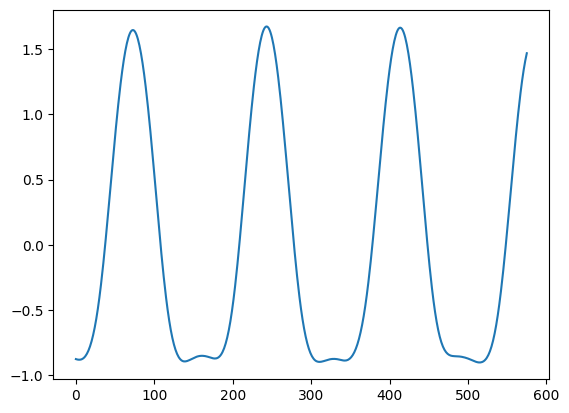

In [306]:
plt.plot(denoised[0][:576])

In [307]:
?plot_acf

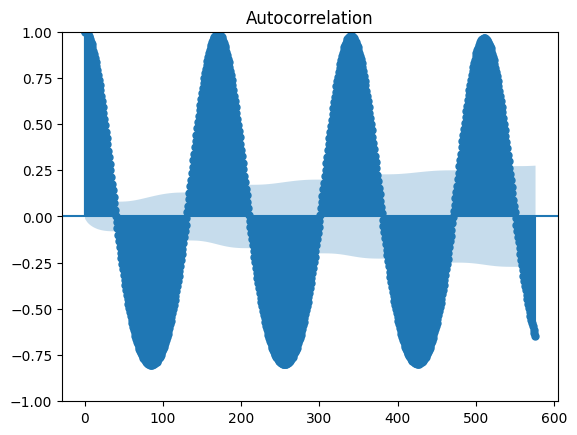

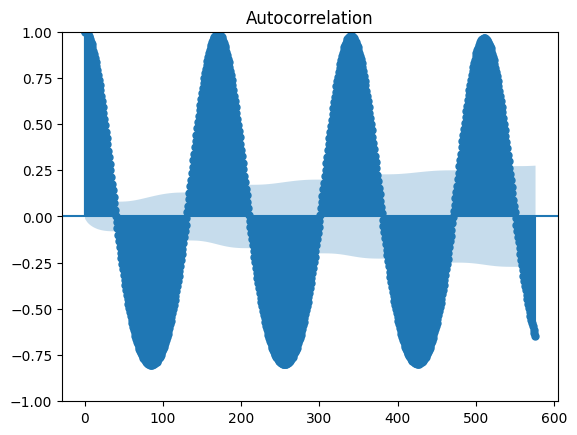

In [309]:
plot_acf(denoised[0][:576*40], lags=576*1)

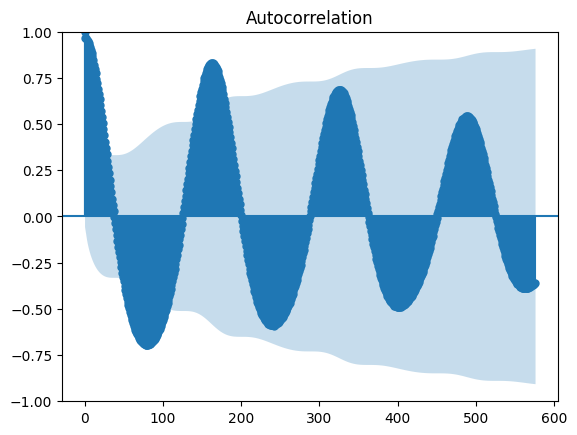

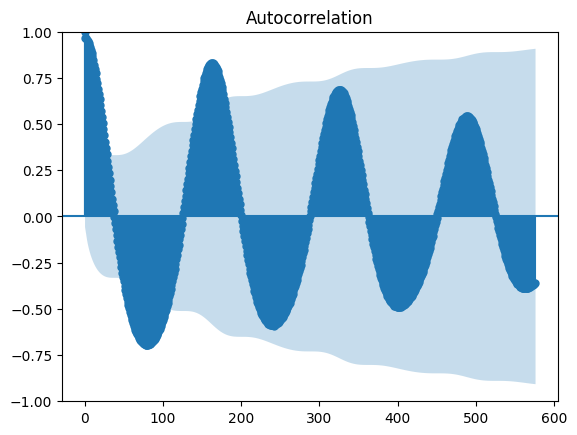

In [13]:
plot_acf(Origin_norm[0,0][:576*2].cpu(), lags=576*1)

In [311]:
fft_signal, freqs = fft_freq(denoised[0][:2000], args.step*60, 10)

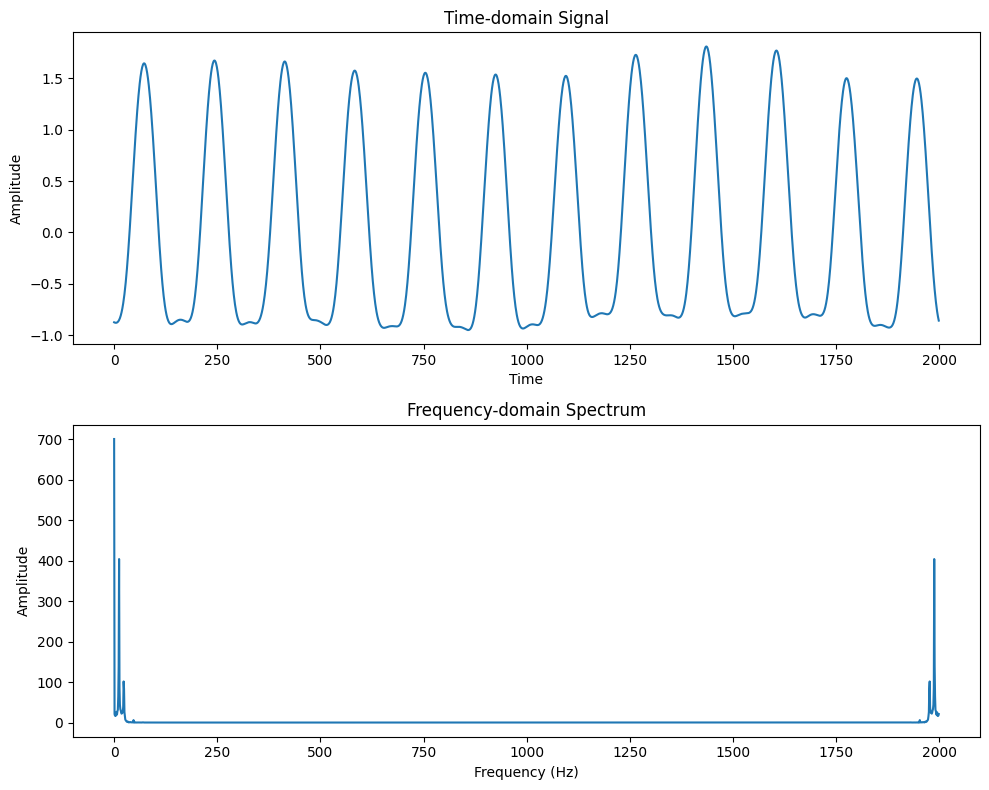

Dominant Frequency: [ 0.     1.728 -1.728 -1.584  1.584  3.312 -3.312  1.872 -1.872 -3.456
  3.456 -1.44   1.44  -2.016  2.016  3.168 -3.168  2.16  -2.16   1.296] Hz
Dominant Amplitude: [700.55273  403.97562  403.97562  139.17421  139.17421  101.54321
 101.54321   85.815414  85.815414  83.31932   83.31932   65.075
  65.075     44.328068  44.328068  38.753223  38.753223  33.267147
  33.267147  31.328114]


In [312]:
plot_fft(denoised[0][:2000], fft_signal, freqs)

In [108]:
Origin_vae[15].T.shape

torch.Size([576, 2])

In [252]:
import tsfel
# Retrieves a pre-defined feature configuration file to extract all available features
cfg = tsfel.get_features_by_domain("statistical")

# Extract features
X = tsfel.time_series_features_extractor(cfg, Origin_vae[0].T, fs=1/(7*12*24), window_size=args.L, overlap=0)
# Y = tsfel.time_series_features_extractor(cfg, denoised)

*** Feature extraction started ***



*** Feature extraction finished ***


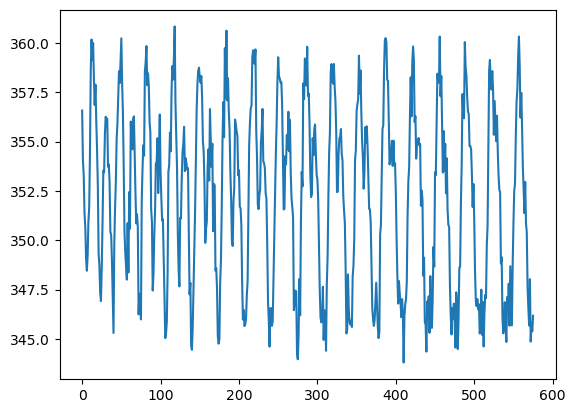

In [258]:
plt.plot(Origin_vae[0].T[:,0])

In [254]:
import pandas as pd
pd.options.display.max_rows = None
pd.set_option('display.float_format', lambda x: f'{x:.3f}')
# X.T.columns = ["val"]
# print(arr[15])
# X = pd.DataFrame(X.values.reshape(28, -1)) 
print(X.shape)
# for el in X:
#     val = X[el].item()
#     if (abs(arr[0]- val) <5).any():
#         print(X[el])
#         print(val)
#     print(X[el].item())
X.T

(1, 80)


,0
0_Absolute energy,71499045.671
0_Average power,61.680
0_ECDF Percentile Count_0,115.000
0_ECDF Percentile Count_1,460.000
0_ECDF Percentile_0,347.165
0_ECDF Percentile_1,356.405
0_ECDF_0,0.002
0_ECDF_1,0.003
0_ECDF_2,0.005
0_ECDF_3,0.007


In [255]:
7.393*5

36.964999999999996

In [5]:
class identifier(nn.Module):
    def __init__(self, args, n_layers, output_size):
        super(identifier, self).__init__()   
        
        self.n_channels =  args.n_channels      
        self.slope = args.slope
        self.n_layers = n_layers
        self.input_size = args.enc_out * args.latent_dims
        self.output_size = output_size
        self.lin_layers = nn.ModuleList()
#         self.n = 1
        
        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.uniform_(m.weight, a=0.0, b=1.0)
                m.bias.data.fill_(0.01)
                
        # Linear Layers
        for i in range(0, n_layers):
            
            if i == self.n_layers -1:
                self.lin_layers.append(nn.Linear(self.input_size, self.output_size))
                self.lin_layers.append(nn.LeakyReLU(self.slope, True))
#                 self.lin_layers.append(nn.BatchNorm1d(self.n))
            else:
                self.lin_layers.append(nn.Linear(self.input_size, self.input_size))
                self.lin_layers.append(nn.LeakyReLU(self.slope, True))
#                 self.lin_layers.append(nn.BatchNorm1d(self.n))
        
        self.lin_layers.apply(init_weights)
            
         
    def forward(self, x):
#         print("x input", x.shape)
#         x_shape = x.shape
        x = x.view(x.size(0), -1)
#         print("x before lin", x.shape)
        for i, lin in enumerate(self.lin_layers):
            x = lin(x)        
#         print("x after lin", x.shape)
#         print("x out", x.shape)
        x = x.view(x.shape[0], -1, self.n_channels)
        return x

In [6]:
def train_identifier_modified(model, id_model, train_loader, optimizer, args, epoch):
    
    device=args.device
    labels_size = id_model.output_size
    n_channels = args.n_channels
    
    id_model.train()
    for p in id_model.parameters():
        p.requires_grad = True
    model.eval()
    for p in model.parameters():
        p.requires_grad = False
    train_loss = 0
    y_pred = torch.empty((0, labels_size//n_channels, n_channels), device=device)
    for batch_idx, (data_tup, label, norm) in enumerate(train_loader):
#         print(data.shape)

        data = pick_data(data_tup, args)
        norm = [n.to(device) for n in norm]
        bs   = data.shape[0]  
        
        x_rec, loss, mu, logvar, mu_rec, logvar_rec, e, indices = model(data, ouput_indices=True)
        label_pred = id_model(e)
#         print(pred.shape)
#         print(label.shape)
        
#         label = label[:,:,1].to(device)
        optimizer.zero_grad()
#         data = data.view(-1, data.shape[2], data.shape[3])
        
#         identified = id_model(data)
# #         print(identified.shape)
# #         print(torch.mean(identified, dim=0))
# #         print(label.shape)
        
#         loss = F.mse_loss(torch.mean(identified, dim=0), labels, reduction='mean')
        loss = F.mse_loss(label_pred, label, reduction='mean')
#         print(loss.shape)
#         # print(x_rec.shape)
#         # print(data[:, :, 0].shape)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        y_pred = torch.cat((y_pred, label_pred), dim = 0) 
        if batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

    return y_pred

def test_identifier_modified(id_model, train_loader, optimizer, device, epoch):
    id_model.train()
    for p in id_model.parameters():
        p.requires_grad = False
    train_loss = 0

    for batch_idx, (data, label, norm) in enumerate(train_loader):

        data = data.to(device)
        label = label[:,:,1].to(device)
#         optimizer.zero_grad()
#         data = data.view(-1, data.shape[2], data.shape[3])
        
        identified = id_model(data)
#         print(identified.shape)
#         print(torch.mean(identified, dim=0))
#         print(label.shape)
#         print(data.shape)
        
#         loss = F.mse_loss(torch.mean(identified, dim=0), labels, reduction='mean')
        loss = F.mse_loss(identified, label, reduction='mean')
#         print(loss)
        # print(x_rec.shape)
        # print(data[:, :, 0].shape)
#         loss.backward()

#         optimizer.step()
        train_loss += loss.item()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
#     print(batch_idx)

    return identified

In [8]:
id_mlp_vae = identifier(args=args, n_layers=1, output_size=20)
id_mlp_vq = identifier(args=args, n_layers=1, output_size=20)

id_mlp_vae = id_mlp_vae.to(args.device)
id_mlp_vq = id_mlp_vq.to(args.device)

id_mlp_vae_opt = optim.Adam(id_mlp_vae.parameters(), lr = 0.01)
id_mlp_vq_opt = optim.Adam(id_mlp_vq.parameters(), lr = 0.01)

# print(id_mlp)

In [31]:
for epoch in range(1,1000):
    y_train_pred_mlp_vae = train_identifier_modified(vae, id_mlp_vae,train_data, id_mlp_vae_opt, args, epoch)
    y_train_pred_mlp_vq = train_identifier_modified(vq, id_mlp_vq,train_data, id_mlp_vq_opt, args, epoch)
# y_test_pred_mlp = test_identifier_modified(id_mlp,test_data, id_mlp_opt, args.device, epoch)

Train Epoch: 1 [0/4000 (0%)]	Loss: 23.429951
====> Epoch: 1 Average loss: 22.9596
Train Epoch: 1 [0/4000 (0%)]	Loss: 20.722834
====> Epoch: 1 Average loss: 19.9793
Train Epoch: 2 [0/4000 (0%)]	Loss: 23.007664
====> Epoch: 2 Average loss: 22.9340
Train Epoch: 2 [0/4000 (0%)]	Loss: 20.836823
====> Epoch: 2 Average loss: 19.9186
Train Epoch: 3 [0/4000 (0%)]	Loss: 22.943308
====> Epoch: 3 Average loss: 22.8672
Train Epoch: 3 [0/4000 (0%)]	Loss: 20.486959
====> Epoch: 3 Average loss: 19.9421
Train Epoch: 4 [0/4000 (0%)]	Loss: 23.338799
====> Epoch: 4 Average loss: 22.9439
Train Epoch: 4 [0/4000 (0%)]	Loss: 20.739182
====> Epoch: 4 Average loss: 19.9770
Train Epoch: 5 [0/4000 (0%)]	Loss: 23.046255
====> Epoch: 5 Average loss: 22.9150
Train Epoch: 5 [0/4000 (0%)]	Loss: 20.667608
====> Epoch: 5 Average loss: 19.9567
Train Epoch: 6 [0/4000 (0%)]	Loss: 23.178526
====> Epoch: 6 Average loss: 22.9021
Train Epoch: 6 [0/4000 (0%)]	Loss: 20.375168
====> Epoch: 6 Average loss: 20.0087
Train Epoch: 7 [

====> Epoch: 50 Average loss: 22.2742
Train Epoch: 50 [0/4000 (0%)]	Loss: 20.486887
====> Epoch: 50 Average loss: 19.7715
Train Epoch: 51 [0/4000 (0%)]	Loss: 22.548325
====> Epoch: 51 Average loss: 22.3063
Train Epoch: 51 [0/4000 (0%)]	Loss: 20.411840
====> Epoch: 51 Average loss: 19.7529
Train Epoch: 52 [0/4000 (0%)]	Loss: 22.697056
====> Epoch: 52 Average loss: 22.2191
Train Epoch: 52 [0/4000 (0%)]	Loss: 20.560034
====> Epoch: 52 Average loss: 19.7772
Train Epoch: 53 [0/4000 (0%)]	Loss: 22.767172
====> Epoch: 53 Average loss: 22.3068
Train Epoch: 53 [0/4000 (0%)]	Loss: 20.522892
====> Epoch: 53 Average loss: 19.6989
Train Epoch: 54 [0/4000 (0%)]	Loss: 22.567060
====> Epoch: 54 Average loss: 22.1888
Train Epoch: 54 [0/4000 (0%)]	Loss: 20.296679
====> Epoch: 54 Average loss: 19.6284
Train Epoch: 55 [0/4000 (0%)]	Loss: 22.465778
====> Epoch: 55 Average loss: 22.2647
Train Epoch: 55 [0/4000 (0%)]	Loss: 20.320126
====> Epoch: 55 Average loss: 19.7532
Train Epoch: 56 [0/4000 (0%)]	Loss: 22

====> Epoch: 99 Average loss: 21.7522
Train Epoch: 99 [0/4000 (0%)]	Loss: 20.253422
====> Epoch: 99 Average loss: 19.5421
Train Epoch: 100 [0/4000 (0%)]	Loss: 21.811581
====> Epoch: 100 Average loss: 21.7344
Train Epoch: 100 [0/4000 (0%)]	Loss: 19.974655
====> Epoch: 100 Average loss: 19.4937
Train Epoch: 101 [0/4000 (0%)]	Loss: 21.840704
====> Epoch: 101 Average loss: 21.7562
Train Epoch: 101 [0/4000 (0%)]	Loss: 20.268091
====> Epoch: 101 Average loss: 19.5479
Train Epoch: 102 [0/4000 (0%)]	Loss: 22.086716
====> Epoch: 102 Average loss: 21.7332
Train Epoch: 102 [0/4000 (0%)]	Loss: 20.398584
====> Epoch: 102 Average loss: 19.6249
Train Epoch: 103 [0/4000 (0%)]	Loss: 21.805859
====> Epoch: 103 Average loss: 21.6888
Train Epoch: 103 [0/4000 (0%)]	Loss: 20.212381
====> Epoch: 103 Average loss: 19.5896
Train Epoch: 104 [0/4000 (0%)]	Loss: 21.818163
====> Epoch: 104 Average loss: 21.7067
Train Epoch: 104 [0/4000 (0%)]	Loss: 20.132553
====> Epoch: 104 Average loss: 19.5840
Train Epoch: 105 [

====> Epoch: 147 Average loss: 21.3906
Train Epoch: 147 [0/4000 (0%)]	Loss: 20.104239
====> Epoch: 147 Average loss: 19.3718
Train Epoch: 148 [0/4000 (0%)]	Loss: 21.459404
====> Epoch: 148 Average loss: 21.3685
Train Epoch: 148 [0/4000 (0%)]	Loss: 20.086704
====> Epoch: 148 Average loss: 19.4027
Train Epoch: 149 [0/4000 (0%)]	Loss: 21.498083
====> Epoch: 149 Average loss: 21.3522
Train Epoch: 149 [0/4000 (0%)]	Loss: 20.123165
====> Epoch: 149 Average loss: 19.4281
Train Epoch: 150 [0/4000 (0%)]	Loss: 21.484680
====> Epoch: 150 Average loss: 21.3252
Train Epoch: 150 [0/4000 (0%)]	Loss: 19.979435
====> Epoch: 150 Average loss: 19.4216
Train Epoch: 151 [0/4000 (0%)]	Loss: 21.429502
====> Epoch: 151 Average loss: 21.2823
Train Epoch: 151 [0/4000 (0%)]	Loss: 20.014097
====> Epoch: 151 Average loss: 19.3452
Train Epoch: 152 [0/4000 (0%)]	Loss: 21.353413
====> Epoch: 152 Average loss: 21.2946
Train Epoch: 152 [0/4000 (0%)]	Loss: 20.183735
====> Epoch: 152 Average loss: 19.3087
Train Epoch: 15

====> Epoch: 195 Average loss: 21.0602
Train Epoch: 195 [0/4000 (0%)]	Loss: 19.826021
====> Epoch: 195 Average loss: 19.1826
Train Epoch: 196 [0/4000 (0%)]	Loss: 20.974003
====> Epoch: 196 Average loss: 20.9809
Train Epoch: 196 [0/4000 (0%)]	Loss: 19.828609
====> Epoch: 196 Average loss: 19.2016
Train Epoch: 197 [0/4000 (0%)]	Loss: 21.266647
====> Epoch: 197 Average loss: 21.0445
Train Epoch: 197 [0/4000 (0%)]	Loss: 19.881777
====> Epoch: 197 Average loss: 19.2616
Train Epoch: 198 [0/4000 (0%)]	Loss: 21.175196
====> Epoch: 198 Average loss: 21.0063
Train Epoch: 198 [0/4000 (0%)]	Loss: 19.904322
====> Epoch: 198 Average loss: 19.2097
Train Epoch: 199 [0/4000 (0%)]	Loss: 20.926289
====> Epoch: 199 Average loss: 20.9995
Train Epoch: 199 [0/4000 (0%)]	Loss: 19.912994
====> Epoch: 199 Average loss: 19.2040
Train Epoch: 200 [0/4000 (0%)]	Loss: 20.985977
====> Epoch: 200 Average loss: 20.9541
Train Epoch: 200 [0/4000 (0%)]	Loss: 20.349407
====> Epoch: 200 Average loss: 19.1879
Train Epoch: 20

KeyboardInterrupt: 

In [18]:
labels[1]

tensor([[    0.0000,   484.0000],
        [    0.0000,     1.0000],
        [    0.0000,     0.0003],
        [    1.0000,    15.0000],
        [    1.0000,     1.0000],
        [    1.0000,     0.0017],
        [    1.0000,    16.5632],
        [    1.0000,    16.0000],
        [    1.0000,    20.7902],
        [    1.0000,    19.0000]])

In [29]:
y_train_pred_mlp_vq[1]

tensor([[ 27.8022,  -3.9967],
        [ 25.9948,  17.7429],
        [ 49.3379, 126.1351],
        [ 20.6318,  14.1363],
        [ 26.3131,  -6.5509],
        [ 27.5100,  -0.9838],
        [ 21.4750,  -4.8189],
        [ 55.4790,   9.7881],
        [ 26.9942,  27.3674],
        [ 27.0772,  52.4181]], grad_fn=<SelectBackward0>)

In [207]:
for batch_idx, (data, label, norm) in enumerate(train_data):

    data = data.to(args.device)
    label = label[:,:,1].to(args.device)
#         optimizer.zero_grad()
#         data = data.view(-1, data.shape[2], data.shape[3])

    identified = id_mlp(data)
    print(identified[0], label[0])

tensor([153.8879,  -0.0000,   6.9853,   3.4626], device='cuda:0') tensor([373.0000,   1.0000,  12.3177,   8.3686], device='cuda:0')
tensor([45.6966, -0.0000, -0.0000, 11.7521], device='cuda:0') tensor([96.0000,  1.0000,  7.8325, 11.1604], device='cuda:0')
tensor([177.7629,   1.6209,  -0.0000,   8.9965], device='cuda:0') tensor([394.0000,   1.0000,   7.1965,  13.0473], device='cuda:0')
tensor([186.5321,   0.2891,   0.5423,   8.1666], device='cuda:0') tensor([469.0000,   1.0000,  11.8901,  13.8836], device='cuda:0')
tensor([-0.0000, -0.0000, 14.8344, -0.0000], device='cuda:0') tensor([133.0000,   1.0000,  13.0515,  13.6680], device='cuda:0')
tensor([291.0201,   0.7340,  -0.0000,  10.4569], device='cuda:0') tensor([377.0000,   1.0000,   7.3017,  11.3262], device='cuda:0')
tensor([-0.0000, -0.0000, 10.8225,  8.2450], device='cuda:0') tensor([217.0000,   1.0000,   8.8992,   9.6648], device='cuda:0')
tensor([-0.0000, -0.0000, 17.6824, -0.0000], device='cuda:0') tensor([229.0000,   1.0000,  1

In [184]:
def extract_id_data(model, train_loader, device):
    X, Y = torch.empty((0, 8, 10), device=device), torch.empty((0,4), device=device)
    for batch_idx, (data, label, norm) in enumerate(train_loader):

        data = data.to(device)
        label = label[:,:,1].to(device)
#         norm = norm.to(device)
        
        mu, logvar = encoder(data)
        z = model.reparametrization_trick(mu, logvar).squeeze(1)
#         print(z.shape)
        
        X = torch.cat((X, z), dim=0)
        Y = torch.cat((Y, label), dim=0)
    return X.cpu().detach(), Y.cpu().detach()

In [185]:
X_train, Y_train = extract_id_data(v, train_data, args.device)
X_val, Y_val = extract_id_data(v, val_data, args.device)
X_test, Y_test = extract_id_data(v, test_data, args.device)

RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 8 but got size 6 for tensor number 1 in the list.

In [186]:
def plot_parameter_scatter(labels, prediction_lin, prediction_f):
    n_features = labels.shape[1]
    x_axis = np.arange(len(labels))
    
    blue_handle = plt.Line2D([], [], color='b', label='Original Data', alpha=0.2)
    red_handle = plt.Line2D([], [], color='r', label='Reconstructions mean')
    titles = ["mean", "Std", "Freaquency per Week", "Amplitude", "Phase"]

    fig, ax = plt.subplots(nrows=n_features, ncols=2,figsize=(20, 16))
    for i in range(n_features):    
        ax[i, 0].scatter(x_axis, labels[:, i], c="b", alpha = 0.5)
        ax[i, 0].scatter(x_axis, prediction_lin[:, i], c="r" , alpha = 0.2)
        ax[i, 0].set_title(titles[i])
        ax[i, 0].legend(handles=[blue_handle, red_handle], loc="upper right")
        
        ax[i, 1].scatter(x_axis, labels[:, i], c="b", alpha = 0.5)
        ax[i, 1].scatter(x_axis, prediction_f[:, i], c="r" , alpha = 0.2)
        ax[i, 1].set_title(titles[i])
        ax[i, 1].legend(handles=[blue_handle, red_handle], loc="upper right")
        set_y_lim(ax[i, 0], i)
        set_y_lim(ax[i, 1], i)
    fig.tight_layout()

In [190]:
def test_identifier(model, id_model, labels, train_loader, criterion, optimizer, device, epoch, VQ=True):
    model.train()
    id_model.train()
    for p in model.parameters():
        p.requires_grad = False
    for p in id_model.parameters():
        p.requires_grad = False
    train_loss = 0
    labels = labels.to(device)

    for batch_idx, (data, v) in enumerate(train_loader):

        data = data.to(device)
        v = v.to(device)
        optimizer.zero_grad()

        if VQ:
            x_rec, loss, mu, logvar, mu_rec, logvar_rec, e = model(data)
        else:
            #             x_rec, mu, logvar = model(data)
            x_rec, mu, logvar = sample_mean(model, data, 10)
            if v.dim() == 1:
                v = v.unsqueeze(-1)
                v = v.unsqueeze(-1)
            # x_rec_window_length = x_rec.shape[2]
            loss = criterion(x_rec * v, data[:, :, 0], mu, logvar)
        identified = id_model(e)

    return torch.mean(identified, dim=0)

In [265]:
!pip install umap

  Preparing metadata (setup.py) ... done
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3542 sha256=6e42543d1d4eead291a1c0ca9df0d6d0ab3e7e0a99b2f2da7481f6c59eac46ec
  Stored in directory: /home/anis/.cache/pip/wheels/15/f1/28/53dcf7a309118ed35d810a5f9cb995217800f3f269ab5771cb
Successfully built umap
